# Intro to how transformer lens works

This notebook shows how to access and modify internal model activations using the transformer lens library (version transformer_lens-1.8.1).

In [12]:
import torch
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dtype = torch.bfloat16
# we want the padding side to be left as we want an easy way to access the last token
padding_side = "left"

Using device: cuda


### Load model

In [14]:
# load model
model_name = "meta-llama/Llama-2-7b-chat-hf"
org_model = AutoModelForCausalLM.from_pretrained(model_name).to(device, dtype=dtype)
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = padding_side

tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# create a hooked transformer
model = HookedTransformer.from_pretrained(model_name, 
                                          hf_model=org_model.to("cpu"),
                                          fold_ln=False, 
                                          center_writing_weights=False, 
                                          center_unembed=False, 
                                          tokenizer=tokenizer,
                                          default_padding_side=padding_side,
                                          dtype=dtype)

model.tokenizer.padding_side = padding_side
model.tokenizer.pad_token = tokenizer.eos_token

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [16]:
org_model = org_model.to(device, dtype=dtype)

# Sanity checks

I ran into some issues while trying to figure out activation addition as the results did not match the results I had gotten with other approaches (custom wrapping mudule and pytorch hooks), so I decided to run some sanity checks on the HookedTransformer.

### Difference in tokenizer

In [17]:
# compare tokenizers
test_sentences = ["The quick brown fox jumps over the lazy dog",
                  "this is another sentence",
                  "and a third one",
                  " some nonsense: sFglk 1   ,.<<< 2lkaAASX#sdfk %js 23 kasdg "]
                
                
org_ids = tokenizer(test_sentences, return_tensors="pt", padding=True).to(device)
ids = model.tokenizer(test_sentences, return_tensors="pt", padding=True).to(device)

print("diff in ids:", (org_ids.input_ids - ids.input_ids).float().pow(2).mean())
print("diff in attention mask:", (org_ids.attention_mask - ids.attention_mask).float().pow(2).mean())

diff in ids: tensor(0., device='cuda:0')
diff in attention mask: tensor(0., device='cuda:0')


### Difference in model output with and without padding being relevant

I get large differences between original and hooked model when using padding.

If I iterate through sentences the difference in logits is smaller but still significant.
When I switch to `dtype=float32` the second issue disappears but differences when using padding is still high.

So there is definitely sth wrong with the padding and probably sth wrong with the precision? I get similar results, for left and right padding.

In [19]:
# compare tokenizers
test_sentences = ["The quick brown fox jumps over the lazy dog",
                  "this is another sentence",
                  "and a third one",
                  " some nonsense: sFglk 1   ,.<<< 2lkaAASX#sdfk %js 23 kasdg "]


# compare model outputs
org_model.eval()
model.eval()
ids = tokenizer(test_sentences, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    org_output = org_model(ids["input_ids"], attention_mask=ids["attention_mask"])
    output = model(ids["input_ids"], attention_mask=ids["attention_mask"], return_type="logits")

print("diff in logits when padding: {:.4g}".format((org_output.logits - output).pow(2).mean()))

# is this difference due to the padding?
diff = 0

for i in range(len(test_sentences)):

    single_id = tokenizer(test_sentences[i], return_tensors="pt").to(device)

    with torch.no_grad():
        org_output = org_model(single_id["input_ids"])
        output = model(single_id["input_ids"], return_type="logits")

    diff += (org_output.logits - output).pow(2).mean()

print("diff in logits no padding: {:.4g}".format(diff.item() / len(test_sentences)))

diff in logits when padding: 11.29
diff in logits no padding: 0.001144


### compare hidden states layerwise

In [20]:
test_sentence = "The quick brown fox jumps over the lazy dog"

org_model.eval()
with torch.no_grad():
    inputs = tokenizer(test_sentence, return_tensors="pt").to(device)
    org_hidden_states = org_model(inputs["input_ids"], output_hidden_states=True)["hidden_states"]

In [21]:
model.eval()
with torch.no_grad():
    inputs = tokenizer(test_sentence, return_tensors="pt").to(device)
    _, cache_tl = model.run_with_cache(inputs["input_ids"])

0: 3.004e-08, 1: 7.525e-07, 2: 9.76e-07, 3: 1.289e-06, 4: 2.116e-06, 5: 2.906e-06, 6: 4.023e-06, 7: 5.424e-06, 8: 7.242e-06, 9: 9.537e-06, 10: 1.168e-05, 11: 1.454e-05, 12: 1.657e-05, 13: 1.86e-05, 14: 2.098e-05, 15: 2.563e-05, 16: 3.076e-05, 17: 3.6e-05, 18: 4.482e-05, 19: 5.817e-05, 20: 7.534e-05, 21: 9.537e-05, 22: 0.0001187, 23: 0.0001478, 24: 0.0001822, 25: 0.000226, 26: 0.0002937, 27: 0.0003567, 28: 0.0004444, 29: 0.0005493, 30: 0.0006752, 31: 0.4336


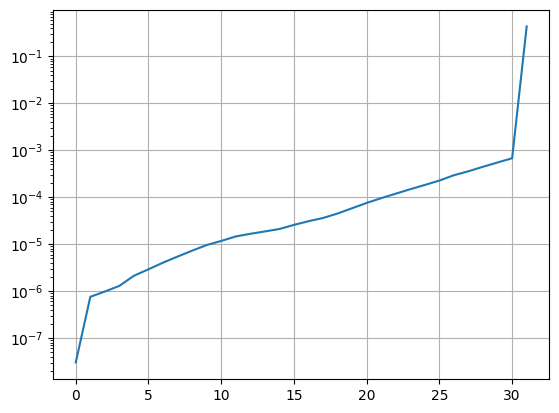

In [22]:
diffs = torch.zeros(len(org_hidden_states)-1)

for layer_id in range(len(org_hidden_states)-1):
    cache_name = f"blocks.{layer_id}.hook_resid_post"
    diffs[layer_id] = (org_hidden_states[layer_id+1] - cache_tl[cache_name]).pow(2).mean().item()

# print diffs with 4 significant digits
print(', '.join("{}: {:.4g}".format(i,value) for i, value in enumerate(diffs)))

# plot the differences in log scale
import matplotlib.pyplot as plt
plt.plot(diffs)
plt.yscale("log")
plt.grid()


# Accessing and modifying internal model activations

### Access hidden activations

We can access hidden activations of the residual streem by passing the `output_hidden_states` keyword. But if we want other hidden states we need some way to hook into the other transformer layers.  

In [23]:
test_sentence = "The quick brown fox jumps over the lazy dog"

org_model.eval()
with torch.no_grad():
    inputs = tokenizer(test_sentence, return_tensors="pt").to(device)
    output = org_model(**inputs, output_hidden_states=True)
    print(output.keys())

odict_keys(['logits', 'past_key_values', 'hidden_states'])


In [24]:
print(f"len hidden states: {len(output.hidden_states)}")
print(f"shape of hidden states: {output.hidden_states[0].shape}")

len hidden states: 33
shape of hidden states: torch.Size([1, 12, 4096])


In [25]:
# the residual layer output of layer layer_id is
# output.hidden_states[layer_id + 1] as the first hidden state is the input embedding
layer_id = 5
hidden_states = output.hidden_states[layer_id + 1]

In [26]:
model.eval()
with torch.no_grad():
    inputs = tokenizer(test_sentence, return_tensors="pt").to(device)
    _, cache = model.run_with_cache(inputs["input_ids"], attention_mask=inputs["attention_mask"])

In [27]:
# define what layer/module you want information from
cache_name = f"blocks.{layer_id}.hook_resid_post"
hidden_states_tl = cache[cache_name]

# mse between the two hidden states
print(f"MSE hidden states: {(hidden_states - hidden_states_tl).pow(2).mean():.4g}")

MSE hidden states: 2.906e-06


In [28]:
# now we can get hidden representations from any block in the transformer
print(f"Available blocks: {cache.keys()}")

Available blocks: dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normal

## Activation addition

Define a direction vector and add it to the internal model activations while generating new model output.

From the transformer lense documentation:

We do this by adding a hook function to that activation. The hook function maps current_activation_value, hook_point to new_activation_value. As the model is run, it computes that activation as normal, and then the hook function is applied to compute a replacement, and that is substituted in for the activation. The hook function can be an arbitrary Python function, so long as it returns a tensor of the correct shape.

In [29]:
max_new_tokens = 30
random_seed = 0
layer_id = 5
cache_name = f"blocks.{layer_id}.hook_resid_post"
token_pos = -1

In [30]:
with torch.no_grad():
    vec1 = model.run_with_cache("Love")[1][cache_name] 
    vec2 = model.run_with_cache("Hate")[1][cache_name] 

print(f"shape vec1: {vec1.shape}")
print(f"shape vec2: {vec2.shape}")

shape vec1: torch.Size([1, 2, 4096])
shape vec2: torch.Size([1, 3, 4096])


In [31]:
# to not use have to store all activations in the cache we can also use hooks to access internal model activations
def get_internal_activations(model, inputs, cache_name, token_pos=-1):

    activations = torch.zeros((len(inputs), 1, model.cfg.d_model), dtype=model.cfg.dtype, device=model.cfg.device)
    def hook_fn(activation, hook):
        activations[:,:,:] = activation[:,token_pos,:].unsqueeze(1)

    model.eval()
    with torch.no_grad():
        _ = model.run_with_hooks(inputs,
                                 fwd_hooks=[(
                                     cache_name, 
                                     hook_fn)])
    
    return activations

sentences = ["Love", "Hate"]
activations = get_internal_activations(model, sentences, cache_name, token_pos=token_pos)

print(f"MSE activations '{sentences[0]}': {(activations[0, 0] - vec1[0, token_pos]).pow(2).mean():.4g}")
print(f"MSE activations '{sentences[1]}': {(activations[1, 0] - vec2[0, token_pos]).pow(2).mean():.4g}")

MSE activations 'Love': 0
MSE activations 'Hate': 0


In [32]:
direction = vec1[:, token_pos] - vec2[:, token_pos]
# reshape to (batch_size, 1, hidden_size)
direction = direction.unsqueeze(1)
print(f"shape direction: {direction.shape}")
print(f"norm of direction: {direction.norm(dim=-1).item():.4g}")

shape direction: torch.Size([1, 1, 4096])
norm of direction: 8.688


In [33]:
# define hook function
def act_add_hook(direction):
    
    def hook_fn(activation, hook):
        output = activation + direction
        return output

    return hook_fn

In [34]:
test_sentences = ["I think dogs are",
                  "I think cats are",
                  "When I wake up, I",
                  "When I go to work, I",
                  "Today I feel",
                  "I am"]

with torch.no_grad():
    # this only sets the hook temporarily
    hooked_output = model.run_with_hooks(
        test_sentences,
        return_type="logits", 
        fwd_hooks=[(
            cache_name, 
            act_add_hook(direction)
            )]
    )

    normal_output = model(test_sentences)
    print(f"difference in logits: {((hooked_output - normal_output)**2).mean():.4g}")

difference in logits: 0.6289


In [35]:
def generate(model, test_sentences, max_new_tokens=20, random_seed=0):
    torch.random.manual_seed(random_seed)
    with torch.no_grad():
        torch.random.manual_seed(random_seed)
        inputs = model.tokenizer(test_sentences, return_tensors="pt", padding=True).to(model.cfg.device)
        # weirdly enough the generate function does not except list of strings...
        # so it's either single string or tensor of tokens (batch_size, seq_len)
        output_tokens = model.generate(inputs["input_ids"], max_new_tokens=max_new_tokens, verbose=False)
        output_sentences = model.tokenizer.batch_decode(output_tokens, skip_special_tokens=True)

        return output_sentences

In [39]:
model.reset_hooks()
model.add_hook(name=cache_name, hook=act_add_hook(direction))

output_sentences = generate(model, test_sentences, max_new_tokens=max_new_tokens, random_seed=random_seed)
print(f"steering in positive direction:\n\n")
for i in range(len(output_sentences)):
    print(f"{output_sentences[i]}")
    print("-"*30)


steering in positive direction:


I think dogs are pretty amazing pets. Here, you'll find many fun and interesting mixes of dogs available for adoption through reputable breed
------------------------------
I think cats are one of the most interesting creatures on planet Earth. What’s not to love about their independence, curiosity, playfulness and independence? It
------------------------------
When I wake up, I reach for his warm embrace. I’m met by a man who is kind, caring and thoughtful. His eyes are like a work
------------------------------
When I go to work, I always see Nishiki’s smile light up as tears brighten up the space. My sleepy smile spreads across the table each time I
------------------------------
Today I feel like going out in my best jumps.
Set Designer | Monique Moonlight
Soft, elegant, and classic, the Monique
------------------------------
I am so so grateful to have the opportunity to work with such a talented and dedicated team of educators, who are passionat

In [40]:
model.reset_hooks()
model.add_hook(name=cache_name, hook=act_add_hook(-direction))

output_sentences = generate(model, test_sentences, max_new_tokens=max_new_tokens, random_seed=random_seed)
print(f"steering in negative direction:\n\n")
for i in range(len(output_sentences)):
    print(f"{output_sentences[i]}")
    print("-"*30)


steering in negative direction:


I think dogs are trainable. And I think some people are just plain mean. As my dad would say, "They'are justifiably angry."

------------------------------
I think cats are evil, but I’m a nice person, Internet Police, You Should Know, HATE & ENJ cosis, lack ,homophate
------------------------------
When I wake up, I fight. I When I fight, I’m brutal. As a people. Like I wake up and all that hate in my heart.
------------------------------
When I go to work, I always feel like I'm avoiding the real problem - the straight white man. Do I need to be sorry? by:Seeing: int
------------------------------
Today I feel like going out and angry-making them. So how do I actually do it? I’m just an angry, non-productive person,
------------------------------
I am so so sorry to hear that."
I hope that you will never have to say that again.
Many people have used the phrase "I'
------------------------------


In [41]:
model.reset_hooks()

output_sentences = generate(model, test_sentences, max_new_tokens=max_new_tokens, random_seed=random_seed)
print(f"no steering:\n\n")
for i in range(len(output_sentences)):
    print(f"{output_sentences[i]}")
    print("-"*30)

no steering:


I think dogs are awesome!
Look at this adorable pupper trying to sleep but having a hard time due to too much excitement and energy:
Malt
------------------------------
I think cats are bonding with their einstien
in the secret garden,
they're happy we're not around to see,
through Rosie
------------------------------
When I wake up, I'm irritable. This is how it has always been. Coffee is the only thing that really helps. As soon as I take
------------------------------
When I go to work, I always see this little gnome hanging out in the bushes near the entrance to the office building. I’ve seen him there every day this
------------------------------
Today I feel like going out for my best coffee with my better half, were actually the new rose coffee house right by the beach, the breeze is so
------------------------------
I am so so so so proud of you!I hope that you will keep up the good work and never give up on your dreams. Always remember that
---------------------